# Unsupervised deep learning approach

### Achievement:
Using a stacked autoencoder we create a binary classifier with the following performance characteristic:

|Precision|Recall|F1  |Precision Attack|Recall Attack|
r|---------|------|----|----------------|-------------|
|0.80     |0.78  |0.78|0.72            |0.90         |


## 1. Introduction

We will use an unsupervised deep learning approach to create a binary classifier based on the ideas of representation learning and anomaly detection. We will train multiple deep learning models on benign data and a small proportion of attacks to have a meaningful representation of the benign data. We want to create a model that can classify network traffic as benign or malicious, for the network traffic is similar or dissimilar to the data the model has been trained with. The reason for using unsupervised learning, in this case, is that benign data is usually easier to obtain and hence can be provided in higher volumes than malicious data.

### Autoencoder
 An autoencoder is a neural network with the goal of learning a dense representation of the input data. It reconstructs the given inputs by initially encoding the input features as dense representations (latent representations orcoding) and then decoding the dense representations to reconstruct the initial inputs. Using this approach, the model should learn the identity function of the input data. To ensure that the model learns a meaningful representation of the data and does not just copy the input features to the output, an autoencoder restricts the model in different ways, for example, by limiting the dimensionality of the latent representations. 



This notebook explores the following architecture variants of autoencoders:
* Undercomplete Autoencoder
* Stacked Autoencoder
* Denoising Autoencoder

## 2. Dataset Preparation

In this section we load the dataset and prepare the data for training. The preprocessed dataset from CIC-IDS-2018

In [8]:
dataset_base_path = r'/nizar/dataset'

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from ml_ids.data.dataset import load_dataset
from ml_ids.transform.preprocessing import create_pipeline
from ml_ids.model_selection import split_x_y
from ml_ids.visualization import plot_confusion_matrix, plot_hist, plot_threshold
from ml_ids.keras.metrics import AveragePrecisionScoreMetric
from ml_ids.keras.callbacks import OneCycleScheduler
from ml_ids.libs.dfencoder.dataframe import EncoderDataFrame
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, mean_squared_error
from sklearn.utils.multiclass import unique_labels
from functools import partial
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers, constraints
from scipy import stats
from ml_ids.notebook_utils import predict, evaluate_pr_roc, plot_evaluation_curves, plot_pr_threshold_curves, best_precision_for_target_recall, print_performance, filter_benign

K = keras.backend

rand_state = 42
tf.random.set_seed(rand_state)
np.random.seed(rand_state)

physical_devices = tf.config.experimental.list_physical_devices('CPU')


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.keras import layers, losses

### 2.1 Data Loading 

In this part we load the dataset and specify two kinds of features:
1. *Features to impute*: these are features containing missing values which will be imputed in a later step.
2. *Features to omit*: these are the features that will not be used for training the model. These encompass all the features having no variance, features having the same distribution for benign and malicious traffic and features which should not be taken into account in order to obtain a better generalization of the model.

In [3]:
cols_to_impute = [
    'flow_duration',
    'flow_byts_s',
    'flow_pkts_s',
    'flow_iat_mean',
    'flow_iat_max',
    'flow_iat_min',
    'fwd_iat_tot',
    'fwd_iat_mean',
    'fwd_iat_max',
    'fwd_iat_min'
]

features_no_variance = [
    "bwd_blk_rate_avg",
    "bwd_byts_b_avg",
    "bwd_pkts_b_avg",
    "bwd_psh_flags",
    "bwd_urg_flags",
    "fwd_blk_rate_avg",
    "fwd_byts_b_avg",
    "fwd_pkts_b_avg"
]

features_same_distribution = [
    'fwd_urg_flags',
    'pkt_len_var',
    'fin_flag_cnt',
    'urg_flag_cnt',
    'cwe_flag_count',
    'down_up_ratio',
    'fwd_act_data_pkts',
    'active_max'
]

omit_cols = features_no_variance + features_same_distribution + ['timestamp', 'dst_port', 'protocol']


In [4]:
df= pd.read_csv('all_data.csv')

In [5]:
def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df

df = replace_infinity_with_mean(df)
df = replace_negative_values_with_mean(df)
df.shape

(16232943, 83)

In [6]:
ids_data=df
ids_data=ids_data.drop(omit_cols,axis=1)

In [7]:
ids_data=ids_data.drop(['Unnamed: 0'],axis=1)

In [8]:
ids_data.rename(columns={'label_code': 'label_cat'}, inplace=True)

In [9]:
ids_data.shape

(16232943, 63)

### 2.2 Data Splitting

In this step we split the dataset into:
- training set,
- validation set and
- test set.

The training set contains all benign data with only .1 of attacks, as we will use benign data as the normal category for our anomaly detection models. The validation and test sets contain benign data as well as malicious data.

In [10]:
benign_mask = ids_data.label_is_attack == 0
attack_mask = ids_data.label_is_attack == 1

train_data, hold_data = train_test_split(ids_data[benign_mask], test_size=0.2, random_state=rand_state)

val_data_benign, test_data_benign = train_test_split(hold_data, test_size=0.5, random_state=rand_state)

val_data_attack, hold_data_attack = (train_test_split(ids_data[attack_mask],
                                                      test_size=0.5,
                                                      stratify=ids_data[attack_mask].label_cat,
                                                      random_state=rand_state))

test_data_attack,train_data_attack = train_test_split(hold_data_attack, test_size=0.1,stratify=hold_data_attack.label_cat, random_state=rand_state)

train_data = train_data.append(train_data_attack) 

X_train_raw, y_train = split_x_y(train_data)
X_val_raw, y_val = split_x_y(val_data_benign.append(val_data_attack))
X_test_raw, y_test = split_x_y(test_data_benign.append(test_data_attack))

print('Samples:')
print('========')
print('Training: {}'.format(X_train_raw.shape))
print('Val:      {}'.format(X_val_raw.shape))
print('Test:     {}'.format(X_test_raw.shape))

print('\nTraining labels:')
print('================')
print(y_train.label.value_counts())
print('\nValidation labels:')
print('==================')
print(y_val.label.value_counts())
print('\nTest labels:')
print('============')
print(y_test.label.value_counts())

del ids_data, train_data, hold_data, val_data_benign, val_data_attack, test_data_benign, test_data_attack
gc.collect()

Samples:
Training: (10925178, 60)
Val:      (2722588, 60)
Test:     (2585177, 60)

Training labels:
Benign                      10787766
DDOS attack-HOIC               34301
DDoS attacks-LOIC-HTTP         28810
DoS attacks-Hulk               23096
Bot                            14310
FTP-BruteForce                  9668
SSH-Bruteforce                  9380
Infilteration                   8097
DoS attacks-SlowHTTPTest        6995
DoS attacks-GoldenEye           2075
DoS attacks-Slowloris            549
DDOS attack-LOIC-UDP              86
Brute Force -Web                  30
Brute Force -XSS                  11
SQL Injection                      4
Name: label, dtype: int64

Validation labels:
Benign                      1348471
DDOS attack-HOIC             343006
DDoS attacks-LOIC-HTTP       288095
DoS attacks-Hulk             230956
Bot                          143095
FTP-BruteForce                96680
SSH-Bruteforce                93794
Infilteration                 80967
DoS attacks

4

In [159]:
train_data_attack.shape

(137412, 63)

### 2.3 Data Preparation

Here we prepare the datasets

In [80]:
y_test.label_is_attack.value_counts()

0    1348471
1     274824
Name: label_is_attack, dtype: int64

In [11]:
pipeline, get_col_names = create_pipeline(X_train_raw, 
                                          imputer_strategy='median',
                                          imputer_cols=cols_to_impute,
                                          scaler=MinMaxScaler)

X_train = pipeline.fit_transform(X_train_raw)
X_val = pipeline.transform(X_val_raw)
X_test = pipeline.transform(X_test_raw)

X_val_benign = filter_benign(X_val, y_val)

column_names = get_col_names()

print('Samples:')
print('========')
print('Training: {}'.format(X_train.shape))
print('Val:      {}'.format(X_val.shape))
print('Test:     {}'.format(X_test.shape))

print('\nMissing values:')
print('===============')
print('Training: {}'.format(np.count_nonzero(np.isnan(X_train))))
print('Val:      {}'.format(np.count_nonzero(np.isnan(X_val))))
print('Test:     {}'.format(np.count_nonzero(np.isnan(X_test))))

print('\nScaling:')
print('========')
print('Training: min={}, max={}'.format(np.min(X_train), np.max(X_train)))
print('Val:      min={}, max={}'.format(np.min(X_val), np.max(X_val)))
print('Test:     min={}, max={}'.format(np.min(X_test), np.max(X_test)))

Samples:
Training: (10925178, 60)
Val:      (2722588, 60)
Test:     (2585177, 60)

Missing values:
Training: 0
Val:      0
Test:     0

Scaling:
Training: min=0.0, max=1.0
Val:      min=0.0, max=1.1165901465654264
Test:     min=0.0, max=1.1934336251122597


## 3. Model Training

In this section we train and evaluate various types of autoencoder architectures to create a binary classifier using anomaly detection.

The following autoencoder architectures are evaluated:
- Undercomplete Autoencoder
- Stacked Autoencoder
- Denoising Autoencoder



As a first step we define the training parameters for all models.

In [12]:
input_dims = X_train.shape[1]
epochs = 50
batch_size = 4096

### 3.1 Undercomplete Autoencoder

The undercomplete autoencoder represents the simplest type of autoencoder, as it uses a single restricted hidden layer containing the latent representations of the data.    

In [162]:
K.clear_session()
gc.collect()

simple_ae = models.Sequential([
    layers.Dense(30, activation='elu', input_shape=[input_dims]),
    layers.Dense(input_dims, activation='sigmoid')
])

simple_ae.compile(optimizer='adam', loss='binary_crossentropy')
simple_ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                1830      
_________________________________________________________________
dense_1 (Dense)              (None, 60)                1860      
Total params: 3,690
Trainable params: 3,690
Non-trainable params: 0
_________________________________________________________________


### Training

In [163]:
early_stopping = callbacks.EarlyStopping(monitor='val_auprc', 
                                         mode='max',
                                         patience=15,                             
                                         restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_auprc', 
                                        mode='max', 
                                        factor=0.2, 
                                        patience=3, 
                                        min_lr=0.0001)

mc = callbacks.ModelCheckpoint(filepath='models/simple_autoencoder_model3.h5',
                               monitor='val_auprc', 
                               mode='max',
                               save_best_only=False, 
                               verbose=0)

hist = simple_ae.fit(x=X_train, 
                     y=X_train, 
                     validation_data=(X_val_benign, X_val_benign),
                     batch_size=batch_size,
                     epochs=epochs,
                     callbacks=[
                         AveragePrecisionScoreMetric(X_val=X_val, y_val=y_val.label_is_attack, batch_size=16384),
                         early_stopping,
                         reduce_lr,
                         mc
                     ])

Epoch 1/50
2668/2668 [==============================] - 39s 14ms/step - loss: 0.1609 - val_loss: 0.0412
 - val_auprc: 0.7797
Epoch 2/50
2668/2668 [==============================] - 37s 14ms/step - loss: 0.0405 - val_loss: 0.0394
 - val_auprc: 0.7637
Epoch 3/50
2668/2668 [==============================] - 37s 14ms/step - loss: 0.0392 - val_loss: 0.0388
 - val_auprc: 0.7300
Epoch 4/50
2668/2668 [==============================] - 38s 14ms/step - loss: 0.0386 - val_loss: 0.0385
 - val_auprc: 0.7439
Epoch 5/50
2668/2668 [==============================] - 37s 14ms/step - loss: 0.0384 - val_loss: 0.0385
 - val_auprc: 0.7363
Epoch 6/50
2668/2668 [==============================] - 37s 14ms/step - loss: 0.0384 - val_loss: 0.0384
 - val_auprc: 0.7317
Epoch 7/50
2668/2668 [==============================] - 37s 14ms/step - loss: 0.0384 - val_loss: 0.0384
 - val_auprc: 0.7324
Epoch 8/50
2668/2668 [==============================] - 37s 14ms/step - loss: 0.0383 - val_loss: 0.0384
 - val_auprc: 0.7267


### Validation

Inspecting the learning curves we observe that the model does not overfit the training data.

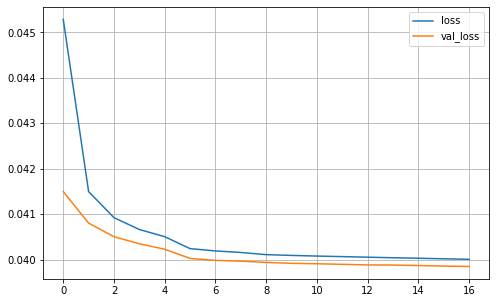

In [195]:
plot_hist(hist)

The plot of the average precision score shows an increase of the score until epoch 8. Afterwards the performance dicrease and then it increases again then it stabilizes and does not increase significantly.

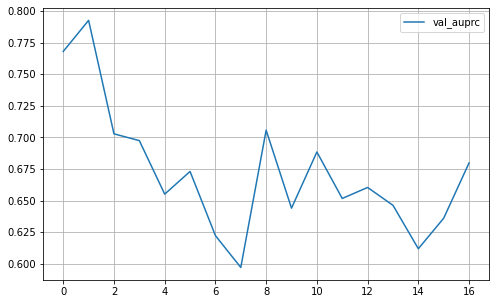

In [196]:
plot_hist(hist, metrics=['val_auprc'])

In [18]:
simple_ae = models.load_model('models/simple_autoencoder_model3.h5')

For this model we obtain an average precision score of `0.79`.

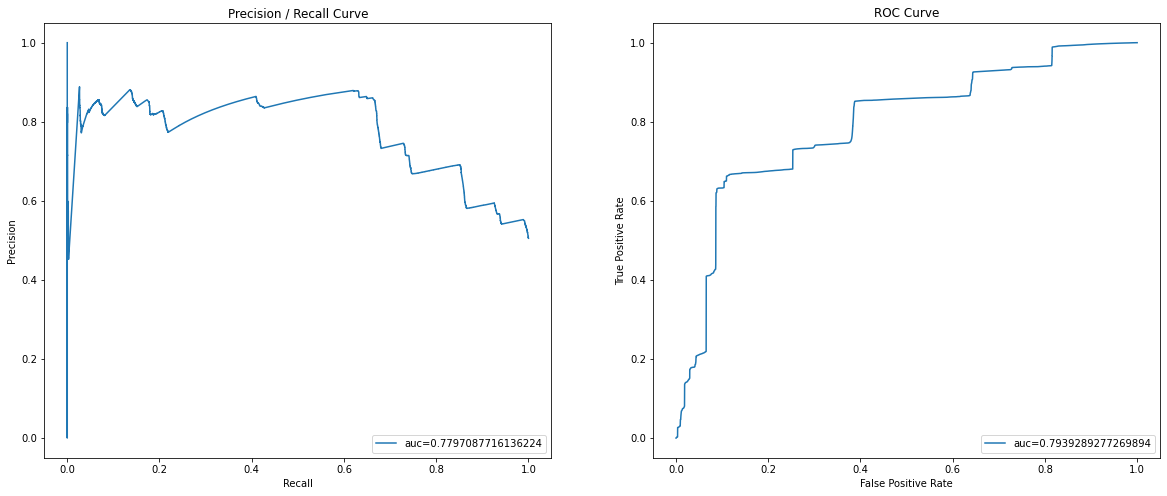

In [164]:
simple_ae = models.load_model('models/simple_autoencoder_model3.h5')
pred_train_simple_ae = predict(simple_ae, X_train, y_train.label_is_attack)
pred_val_simple_ae = predict(simple_ae, X_val, y_val.label_is_attack)

plot_evaluation_curves(pred_val_simple_ae)

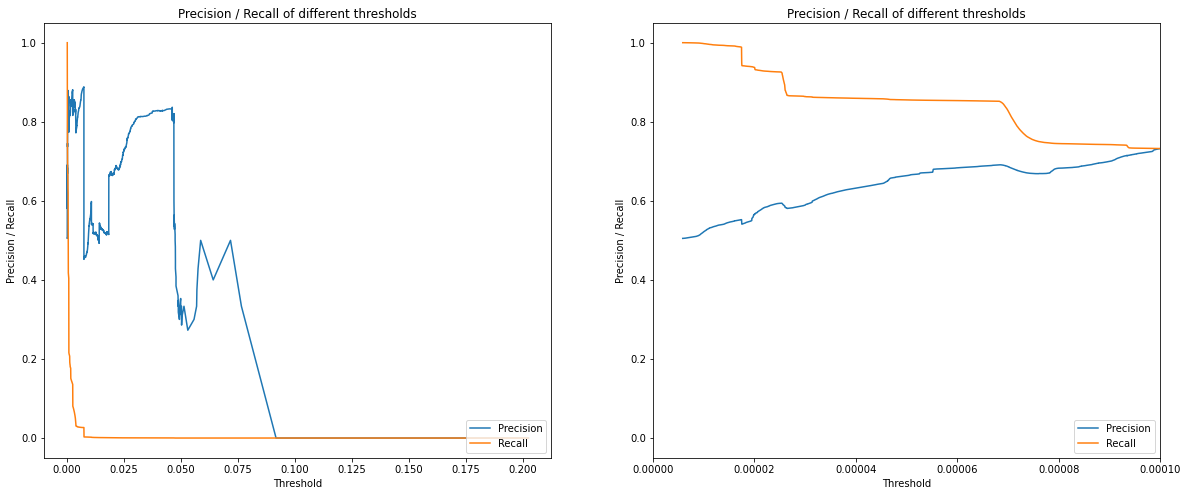

In [197]:
plot_pr_threshold_curves(pred_val_simple_ae, pr_plot_lim=[0, 0.0001])

In the next step we choose a threshold to define the decision boundary, used to separate benign and malicious data, by utilizing the validation data.    
The threshold is chosen to obtain a minimum recall of `0.85`.

In [206]:
threshold_simple_ae = best_precision_for_target_recall(pred_val_simple_ae, target_recall=0.85)
print(threshold_simple_ae)

6.857307586890063e-05


The following plot illustrates the distributions of benign and malicious data, outlining the decision boundary.    
We can observe that the overlap of both traffic classes is quite large.

C:\Users\nizar\.conda\envs\PythonCPU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nizar\.conda\envs\PythonCPU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nizar\.conda\envs\PythonCPU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

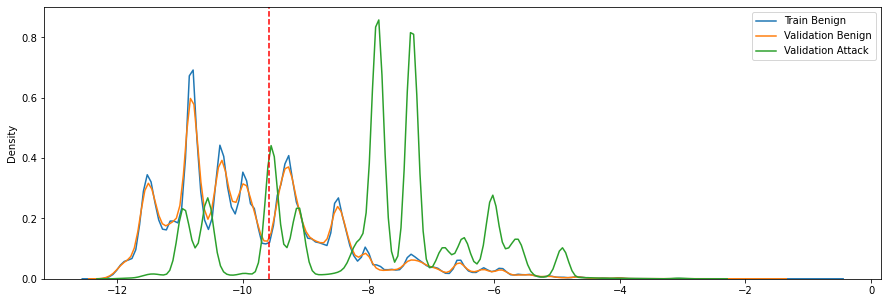

In [208]:
plot_threshold(pred_train_simple_ae, pred_val_simple_ae, threshold_simple_ae, transform=np.log)

### Performance

The performance of this model seems compelling, given that the model is rather simple.

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.61      0.69   1348471
           1       0.69      0.85      0.76   1374117

    accuracy                           0.73   2722588
   macro avg       0.75      0.73      0.73   2722588
weighted avg       0.75      0.73      0.73   2722588

Confusion Matrix:


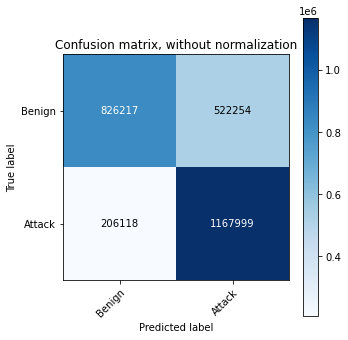

Misclassifications by attack category:


,misclassified,total,percent_misclassified
SQL Injection,27,44,0.613636
Bot,71639,143095,0.500639
Infilteration,39148,80967,0.483506
Brute Force -XSS,49,115,0.426087
Benign,522254,1348471,0.387293
Brute Force -Web,93,306,0.303922
DDOS attack-HOIC,81866,343006,0.238672
DDoS attacks-LOIC-HTTP,13295,288095,0.046148
DoS attacks-GoldenEye,1,20754,0.000048


In [207]:
print_performance(y_val, pred_val_simple_ae, threshold=threshold_simple_ae)

### 3.2 Stacked Autoencoder
The main idea of the stacked autoencoder is to modify an undercomplete autoencoder by adding additional hidden layers, transforming the undercomplete autoencoder into a deep learning model. Adding more layers allows the autoencoder to create more complex representations, which can enhance performance. However, one has to pay attention not to make the autoencoder too powerfull as it might simply recreate the outputs by copying the given inputs if possible.
Figure 3 illustrated the architecture of a stacked autoencoder.

In [170]:
K.clear_session()
gc.collect()

activation = 'elu'
dropout= 0.1

stacked_ae = models.Sequential([
    layers.Dense(50, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0), input_shape=(input_dims,)),
    layers.Dense(30, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0)),
    layers.Dense(20, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0)),
    layers.Dense(10, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0)),
    layers.Dense(20, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(30, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(50, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(input_dims, activation='sigmoid')
])

stacked_ae.compile(optimizer='adam', loss='binary_crossentropy')
stacked_ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                6

In [171]:
early_stopping = callbacks.EarlyStopping(monitor='val_auprc', 
                                         mode='max',
                                         patience=15,                             
                                         restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_auprc', 
                                        mode='max', 
                                        factor=0.2, 
                                        patience=3, 
                                        min_lr=0.0001)

mc = callbacks.ModelCheckpoint(filepath='models/stacked_autoencoder_model.h5',
                               monitor='val_auprc', 
                               mode='max',
                               save_best_only=False, 
                               verbose=0)

hist = stacked_ae.fit(x=X_train, 
                      y=X_train, 
                      validation_data=(X_val_benign, X_val_benign),
                      batch_size=batch_size,
                      epochs=epochs,
                      callbacks=[
                          AveragePrecisionScoreMetric(X_val=X_val, y_val=y_val.label_is_attack, batch_size=16384),
                          early_stopping,
                          reduce_lr,
                          mc
                      ])

Epoch 1/50
2668/2668 [==============================] - 100s 37ms/step - loss: 0.1023 - val_loss: 0.0404
 - val_auprc: 0.8005
Epoch 2/50
2668/2668 [==============================] - 84s 31ms/step - loss: 0.0418 - val_loss: 0.0392
 - val_auprc: 0.8112
Epoch 3/50
2668/2668 [==============================] - 85s 32ms/step - loss: 0.0404 - val_loss: 0.0389
 - val_auprc: 0.8048
Epoch 4/50
2668/2668 [==============================] - 78s 29ms/step - loss: 0.0399 - val_loss: 0.0388
 - val_auprc: 0.8392
Epoch 5/50
2668/2668 [==============================] - 79s 30ms/step - loss: 0.0396 - val_loss: 0.0387
 - val_auprc: 0.8555
Epoch 6/50
2668/2668 [==============================] - 81s 30ms/step - loss: 0.0395 - val_loss: 0.0386
 - val_auprc: 0.8532
Epoch 7/50
2668/2668 [==============================] - 79s 30ms/step - loss: 0.0393 - val_loss: 0.0385
 - val_auprc: 0.7890
Epoch 8/50
2668/2668 [==============================] - 80s 30ms/step - loss: 0.0392 - val_loss: 0.0385
 - val_auprc: 0.7944

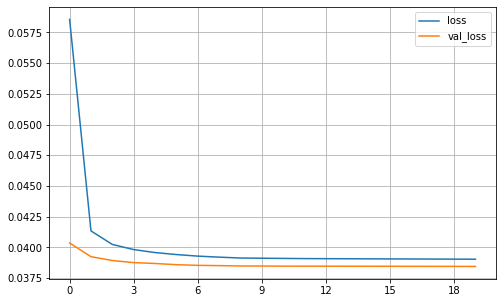

In [172]:
plot_hist(hist)

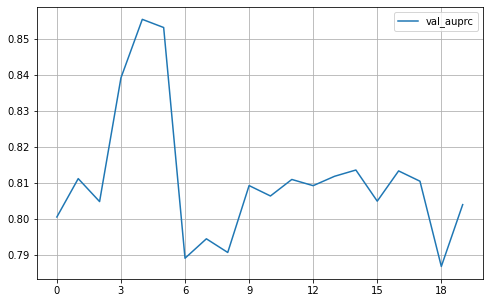

In [173]:
plot_hist(hist, metrics=['val_auprc'])

Here, the average precision score is .86

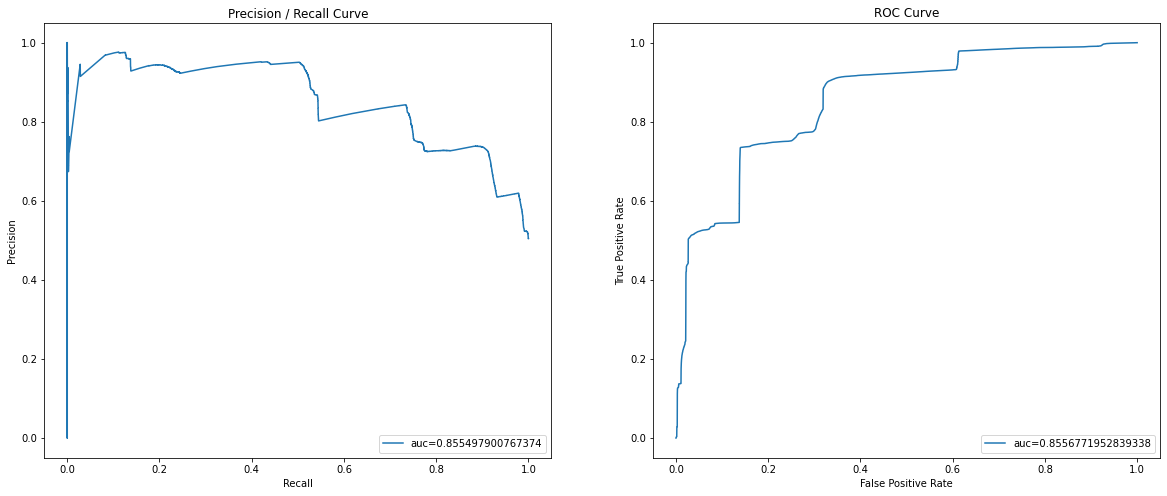

In [174]:
stacked_ae = models.load_model('models/stacked_autoencoder_model.h5')
pred_train_stacked_ae = predict(stacked_ae, X_train, y_train.label_is_attack)
pred_val_stacked_ae = predict(stacked_ae, X_val, y_val.label_is_attack)

plot_evaluation_curves(pred_val_stacked_ae)

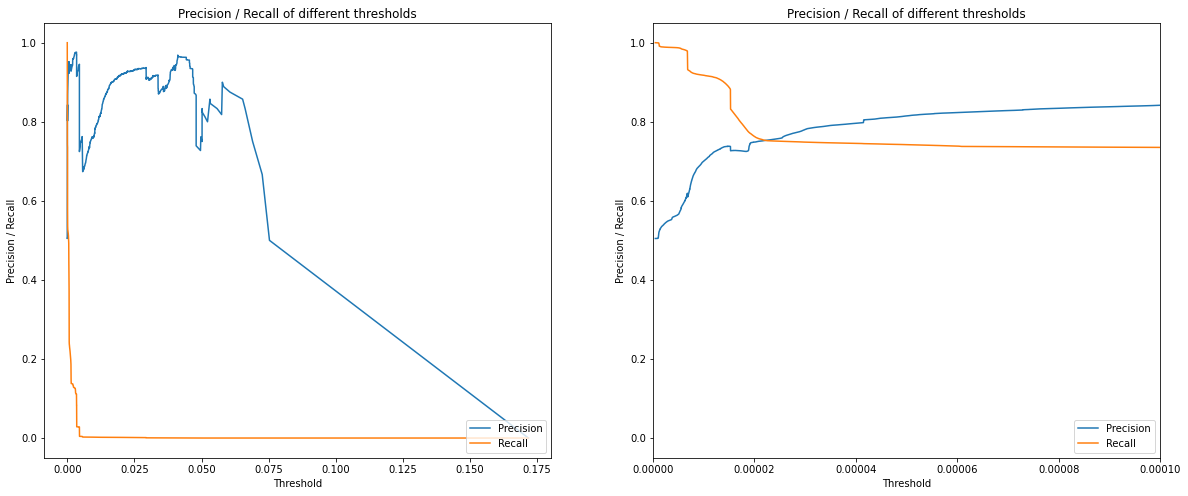

In [175]:
plot_pr_threshold_curves(pred_val_stacked_ae, pr_plot_lim=[0, 0.0001])

In [191]:
threshold_stacked_ae = best_precision_for_target_recall(pred_val_stacked_ae, target_recall=0.9)
print(threshold_stacked_ae)

1.4006262454069351e-05


C:\Users\nizar\.conda\envs\PythonCPU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nizar\.conda\envs\PythonCPU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nizar\.conda\envs\PythonCPU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

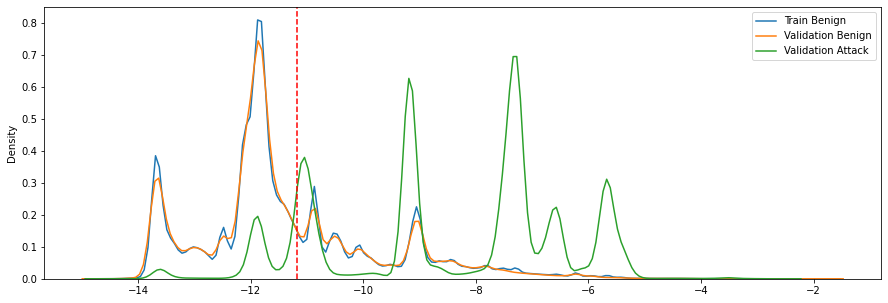

In [177]:
plot_threshold(pred_train_stacked_ae, pred_val_stacked_ae, threshold_stacked_ae, transform=np.log)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.67      0.76   1348471
           1       0.74      0.90      0.81   1374117

    accuracy                           0.79   2722588
   macro avg       0.80      0.79      0.78   2722588
weighted avg       0.80      0.79      0.78   2722588

Confusion Matrix:


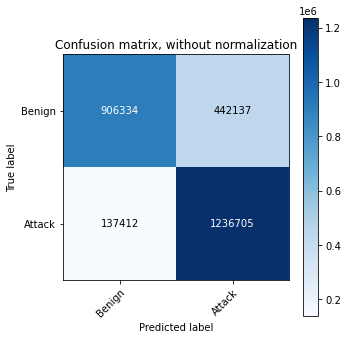

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,44269,80967,0.546754
Bot,71924,143095,0.502631
Brute Force -XSS,49,115,0.426087
Benign,442137,1348471,0.327880
Brute Force -Web,82,306,0.267974
SQL Injection,11,44,0.250000
DDoS attacks-LOIC-HTTP,21070,288095,0.073136
DDOS attack-LOIC-UDP,6,865,0.006936
DoS attacks-GoldenEye,1,20754,0.000048


In [192]:
print_performance(y_val, pred_val_stacked_ae, threshold=threshold_stacked_ae)

### 3.3 Denoising Autoencoder

Another variant of the autoencoder is the denoising autoencoder. In this version, the model is restricted not by limiting the size of the hidden layers but by adding additional noise to the inputs. The objective of the model is to recreate the inputs without containing the noise.    


In [181]:
X_train_swapped = EncoderDataFrame(pd.DataFrame(data=X_train).copy()).swap(likelihood=.15).values
X_val_benign_swapped = EncoderDataFrame(pd.DataFrame(data=X_val_benign).copy()).swap(likelihood=.15).values

In [182]:
K.clear_session()
gc.collect()

activation = 'elu' 
dropout = 0.1

denoising_ae = models.Sequential([
    layers.Dense(512, activation=activation, input_shape=[input_dims]),
    layers.Dropout(dropout),
    layers.Dense(512, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(512, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(512, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(512, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(input_dims, activation='sigmoid')
])

denoising_ae.compile(optimizer='adam', loss='binary_crossentropy')
denoising_ae.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               31232     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

### Training

In [183]:
early_stopping = callbacks.EarlyStopping(monitor='val_auprc', 
                                         mode='max',
                                         patience=15,                             
                                         restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_auprc', 
                                        mode='max', 
                                        factor=0.2, 
                                        patience=3, 
                                        min_lr=0.0001)

mc = callbacks.ModelCheckpoint(filepath='models/denoising_autoencoder_model.h5', 
                               monitor='val_auprc', 
                               mode='max',
                               save_best_only=False, 
                               verbose=0)

hist = denoising_ae.fit(x=X_train_swapped, 
                        y=X_train, 
                        validation_data=(X_val_benign_swapped, X_val_benign),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[
                            AveragePrecisionScoreMetric(X_val=X_val, y_val=y_val.label_is_attack, batch_size=16384),
                            early_stopping,
                            reduce_lr,
                            mc
                        ])

Epoch 1/50
2668/2668 [==============================] - 1267s 474ms/step - loss: 0.0546 - val_loss: 0.0415
 - val_auprc: 0.7680
Epoch 2/50
2668/2668 [==============================] - 1277s 478ms/step - loss: 0.0417 - val_loss: 0.0408
 - val_auprc: 0.7926
Epoch 3/50
2668/2668 [==============================] - 1287s 482ms/step - loss: 0.0410 - val_loss: 0.0405
 - val_auprc: 0.7028
Epoch 4/50
2668/2668 [==============================] - 1272s 477ms/step - loss: 0.0407 - val_loss: 0.0403
 - val_auprc: 0.6974
Epoch 5/50
2668/2668 [==============================] - 1275s 478ms/step - loss: 0.0405 - val_loss: 0.0402
 - val_auprc: 0.6551
Epoch 6/50
2668/2668 [==============================] - 1272s 477ms/step - loss: 0.0403 - val_loss: 0.0400
 - val_auprc: 0.6730
Epoch 7/50
2668/2668 [==============================] - 1273s 477ms/step - loss: 0.0402 - val_loss: 0.0400
 - val_auprc: 0.6223
Epoch 8/50
2668/2668 [==============================] - 1268s 475ms/step - loss: 0.0402 - val_loss: 0.04

### Validation

The learning curves suggest that the model does not overfit the training data. As we use `Dropout` layers the validation loss is lower than the training loss.

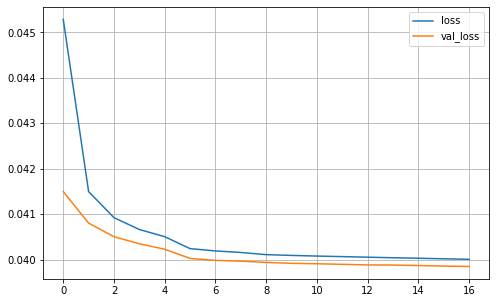

In [193]:
plot_hist(hist)

The plot of the average precision score unveils a very unstable performance progression, with the best score obtained at epoch 17.

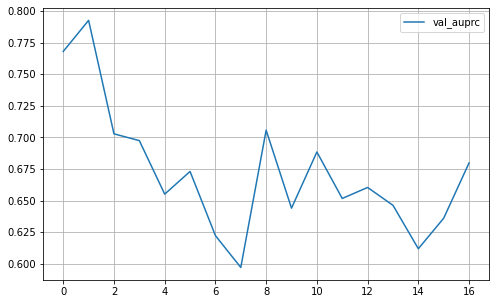

In [194]:
plot_hist(hist, metrics=['val_auprc'])

Using this model we obtain an average precision score of `0.80`.

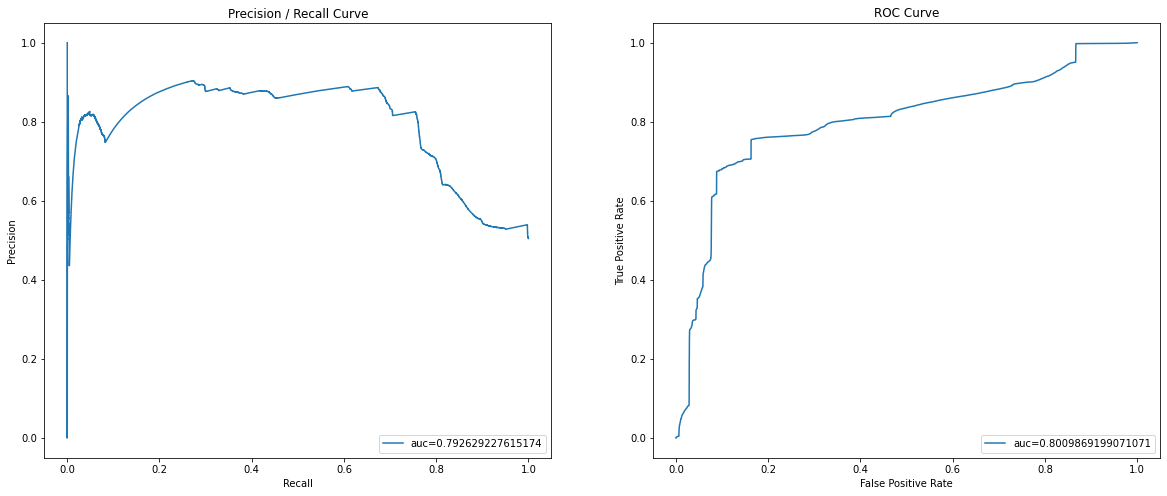

In [184]:
denoising_ae = models.load_model('models/denoising_autoencoder_model.h5')
pred_train_denoising_ae = predict(denoising_ae, X_train, y_train.label_is_attack)
pred_val_denoising_ae = predict(denoising_ae, X_val, y_val.label_is_attack)

plot_evaluation_curves(pred_val_denoising_ae)

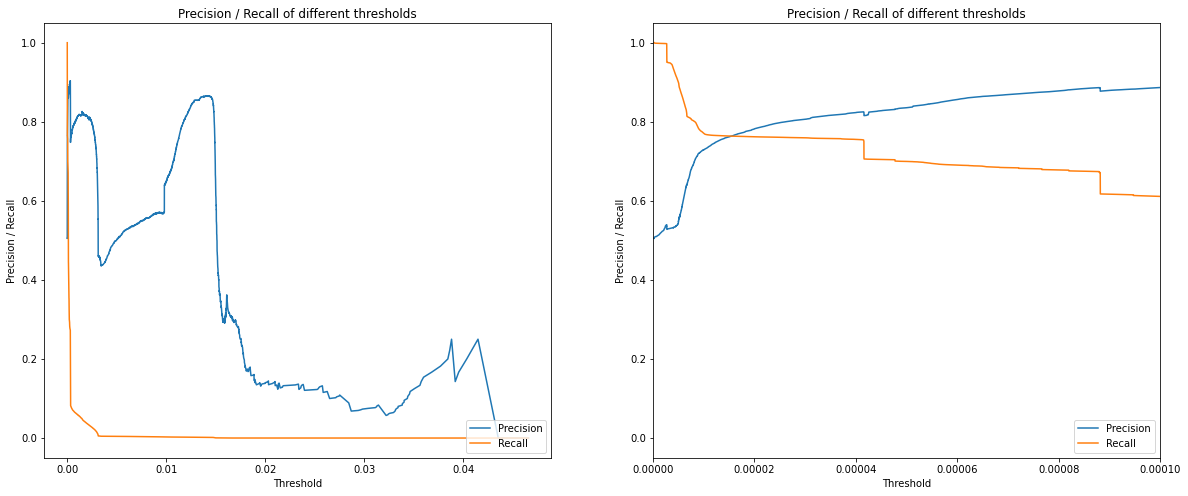

In [185]:
plot_pr_threshold_curves(pred_val_denoising_ae, pr_plot_lim=[0, 0.0001])

As before, we choose a threshold to define the decision boundary using the validation data.    
The threshold is chosen to obtain a minimum recall of `0.8`.

In [188]:
threshold_denoising_ae = best_precision_for_target_recall(pred_val_denoising_ae, target_recall=0.8)
print(threshold_denoising_ae)

8.266954947277741e-06


The distribution plot shows some overlap of benign and malicious traffic.

C:\Users\nizar\.conda\envs\PythonCPU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nizar\.conda\envs\PythonCPU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\nizar\.conda\envs\PythonCPU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

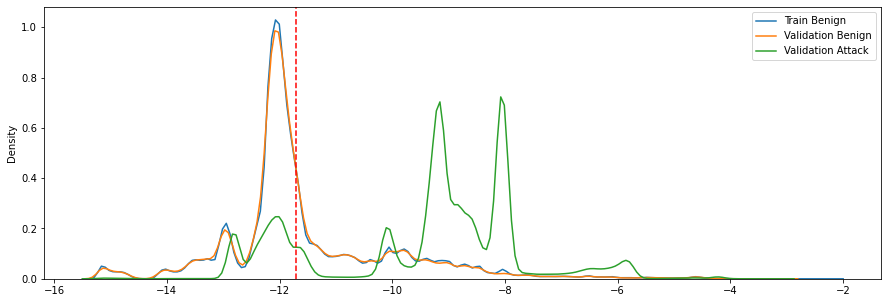

In [190]:
plot_threshold(pred_train_denoising_ae, pred_val_denoising_ae, threshold_denoising_ae, transform=np.log)

### Performance

The performance of the denoising autoencoder surpasses the performance of the other models.

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.66      0.71   1348471
           1       0.70      0.80      0.75   1374117

    accuracy                           0.73   2722588
   macro avg       0.73      0.73      0.73   2722588
weighted avg       0.73      0.73      0.73   2722588

Confusion Matrix:


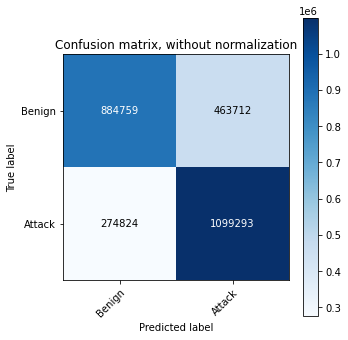

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DDoS attacks-LOIC-HTTP,152788,288095,0.530339
Infilteration,42685,80967,0.527190
Bot,73741,143095,0.515329
Brute Force -XSS,48,115,0.417391
Benign,463712,1348471,0.343880
Brute Force -Web,65,306,0.212418
SQL Injection,5,44,0.113636
SSH-Bruteforce,5491,93794,0.058543
DoS attacks-GoldenEye,1,20754,0.000048


In [189]:
print_performance(y_val, pred_val_denoising_ae, threshold=threshold_denoising_ae)

## 4. Performance on Test Set

In this section we evaluate the performance on the test set.

#### Under complete autoencoder

Average Precision Score: 0.7628039519678446

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.61      0.70   1348471
           1       0.67      0.85      0.75   1236706

    accuracy                           0.73   2585177
   macro avg       0.74      0.73      0.72   2585177
weighted avg       0.75      0.73      0.72   2585177

Confusion Matrix:


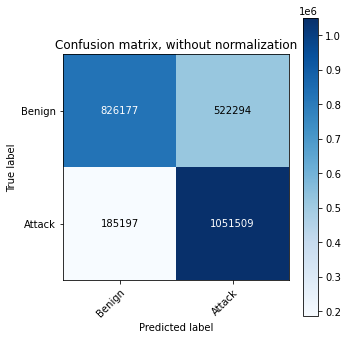

Misclassifications by attack category:


,misclassified,total,percent_misclassified
SQL Injection,24,39,0.615385
Brute Force -XSS,56,104,0.538462
Bot,64030,128786,0.497181
Infilteration,35270,72870,0.484013
Benign,522294,1348471,0.387323
Brute Force -Web,86,275,0.312727
DDOS attack-HOIC,73699,308705,0.238736
DDoS attacks-LOIC-HTTP,12032,259286,0.046404


In [212]:
pred_test_simple_ae = predict(simple_ae, X_test, y_test.label_is_attack)

test_avg_pr_score = average_precision_score(pred_test_simple_ae.y_true, pred_test_simple_ae.rec_error)
print('Average Precision Score: {}\n'.format(test_avg_pr_score))    
print_performance(y_test, pred_test_simple_ae, threshold=threshold_simple_ae)

#### Stacked autoencoder

Average Precision Score: 0.8437813054234123

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76   1348471
           1       0.72      0.90      0.80   1236706

    accuracy                           0.78   2585177
   macro avg       0.80      0.79      0.78   2585177
weighted avg       0.80      0.78      0.78   2585177

Confusion Matrix:


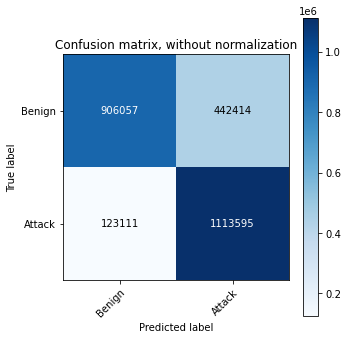

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,39926,72870,0.547907
Brute Force -XSS,55,104,0.528846
Bot,64284,128786,0.499154
Benign,442414,1348471,0.328086
Brute Force -Web,78,275,0.283636
SQL Injection,11,39,0.282051
DDoS attacks-LOIC-HTTP,18756,259286,0.072337
DDOS attack-LOIC-UDP,1,779,0.001284


In [213]:
pred_test_stacked_ae = predict(stacked_ae, X_test, y_test.label_is_attack)

test_avg_pr_score = average_precision_score(pred_test_stacked_ae.y_true, pred_test_stacked_ae.rec_error)
print('Average Precision Score: {}\n'.format(test_avg_pr_score))    
print_performance(y_test, pred_test_stacked_ae, threshold=threshold_stacked_ae)

#### Denoising autoencoder

Average Precision Score: 0.7767891082757601

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.66      0.71   1348471
           1       0.68      0.80      0.74   1236706

    accuracy                           0.73   2585177
   macro avg       0.73      0.73      0.72   2585177
weighted avg       0.73      0.73      0.72   2585177

Confusion Matrix:


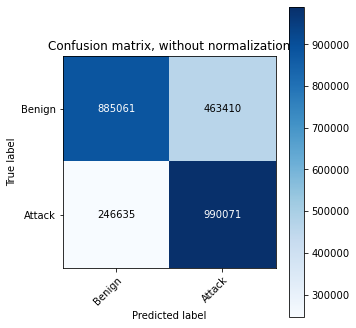

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DDoS attacks-LOIC-HTTP,137285,259286,0.529473
Infilteration,38446,72870,0.527597
Bot,65839,128786,0.511228
Brute Force -XSS,52,104,0.500000
Benign,463410,1348471,0.343656
Brute Force -Web,66,275,0.240000
SQL Injection,8,39,0.205128
SSH-Bruteforce,4939,84415,0.058509


In [214]:
pred_test_denoising_ae = predict(denoising_ae, X_test, y_test.label_is_attack)

test_avg_pr_score = average_precision_score(pred_test_denoising_ae.y_true, pred_test_denoising_ae.rec_error)
print('Average Precision Score: {}\n'.format(test_avg_pr_score))    
print_performance(y_test, pred_test_denoising_ae, threshold=threshold_denoising_ae)

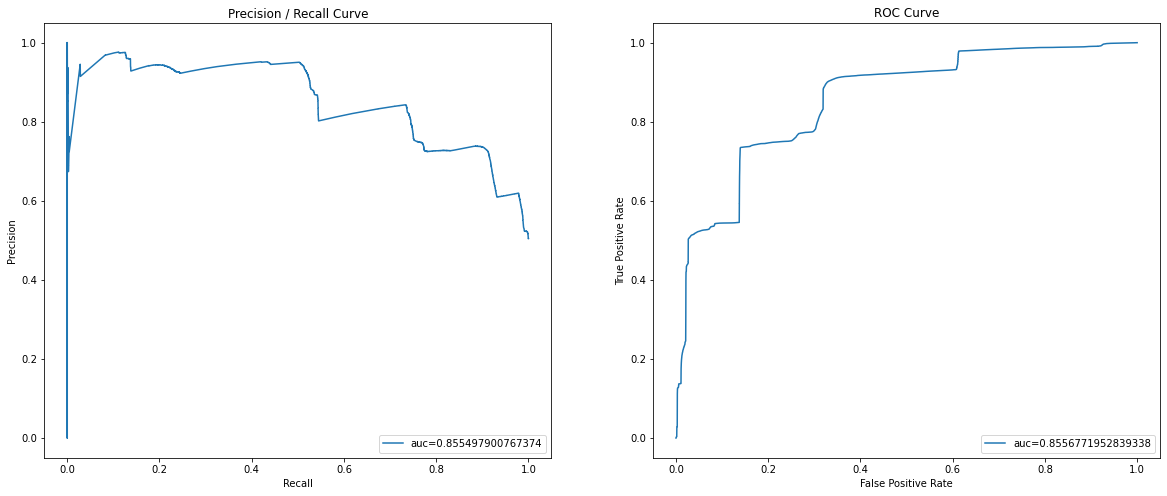

In [13]:
stacked_ae = models.load_model('models/stacked_autoencoder_model.h5')
pred_train_stacked_ae = predict(stacked_ae, X_train, y_train.label_is_attack)
pred_val_stacked_ae = predict(stacked_ae, X_val, y_val.label_is_attack)

plot_evaluation_curves(pred_val_stacked_ae)

In [16]:
pred_test_stacked_ae = predict(stacked_ae, X_test, y_test.label_is_attack)

In [35]:
pred_binary_train = (pred_train_stacked_ae.rec_error >= 1.4006262454069351e-05).astype('int')
pred_binary_test = (pred_test_stacked_ae.rec_error >= 1.4006262454069351e-05).astype('int')
pred_binary_val = (pred_val_stacked_ae.rec_error >= 1.4006262454069351e-05).astype('int')

In [36]:
tt = X_train_raw.copy()
yy = X_test_raw.copy()
vv = X_val_raw.copy()

In [37]:
tt['slabel']= list(pred_binary_train)
yy['slabel']= list(pred_binary_test)
vv['slabel']= list(pred_binary_val)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool

In [32]:
def print_report(ds_type, cls, X_vals, y_true, y_predict, plot_pr=False, plot_roc=False):
    print(f"Classification Report ({ds_type}):")
    print(classification_report(y_true, y_predict))
    print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    
    if plot_roc:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_predict)}")
        skplt.metrics.plot_roc(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    if plot_pr:
        
        skplt.metrics.plot_precision_recall(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    print('\n')

In [29]:
model2 = RandomForestClassifier(verbose=1, n_jobs=32, class_weight='balanced')
model2.fit(tt, y_train.label_is_attack)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed: 18.9min finished


RandomForestClassifier(class_weight='balanced', n_jobs=32, verbose=1)

In [30]:
y_pred_rf = model2.predict(yy)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    7.6s finished


In [33]:
print_report('Test', model2, yy, y_test.label_is_attack, y_pred_rf)

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97   1348471
           1       0.99      0.95      0.97   1236706

    accuracy                           0.97   2585177
   macro avg       0.97      0.97      0.97   2585177
weighted avg       0.97      0.97      0.97   2585177

Avg Precision Score: 0.9667768360813676




In [38]:
model2.fit(vv, y_val.label_is_attack)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  3.0min finished


RandomForestClassifier(class_weight='balanced', n_jobs=32, verbose=1)

In [39]:
y_pred_rf = model2.predict(yy)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    8.6s finished


In [40]:
print_report('Test', model2, yy, y_test.label_is_attack, y_pred_rf)

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97   1348471
           1       0.98      0.96      0.97   1236706

    accuracy                           0.97   2585177
   macro avg       0.97      0.97      0.97   2585177
weighted avg       0.97      0.97      0.97   2585177

Avg Precision Score: 0.9603028775911219


